In this notebook we're going to discuss the window's size, the features' extraction and the features' selection.

For the window's size, let's consider 3 different windows' sizes, for example looking at walking, and compare the signals. We expect that if we choose a low window size the algorithm won't be able to correctly characterize the signal, and then it won't be able to classify it. On the other hand, if we select a too large window size we loose in terms of responsiveness of the application that we'll take in exam later.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append("creation_functions")

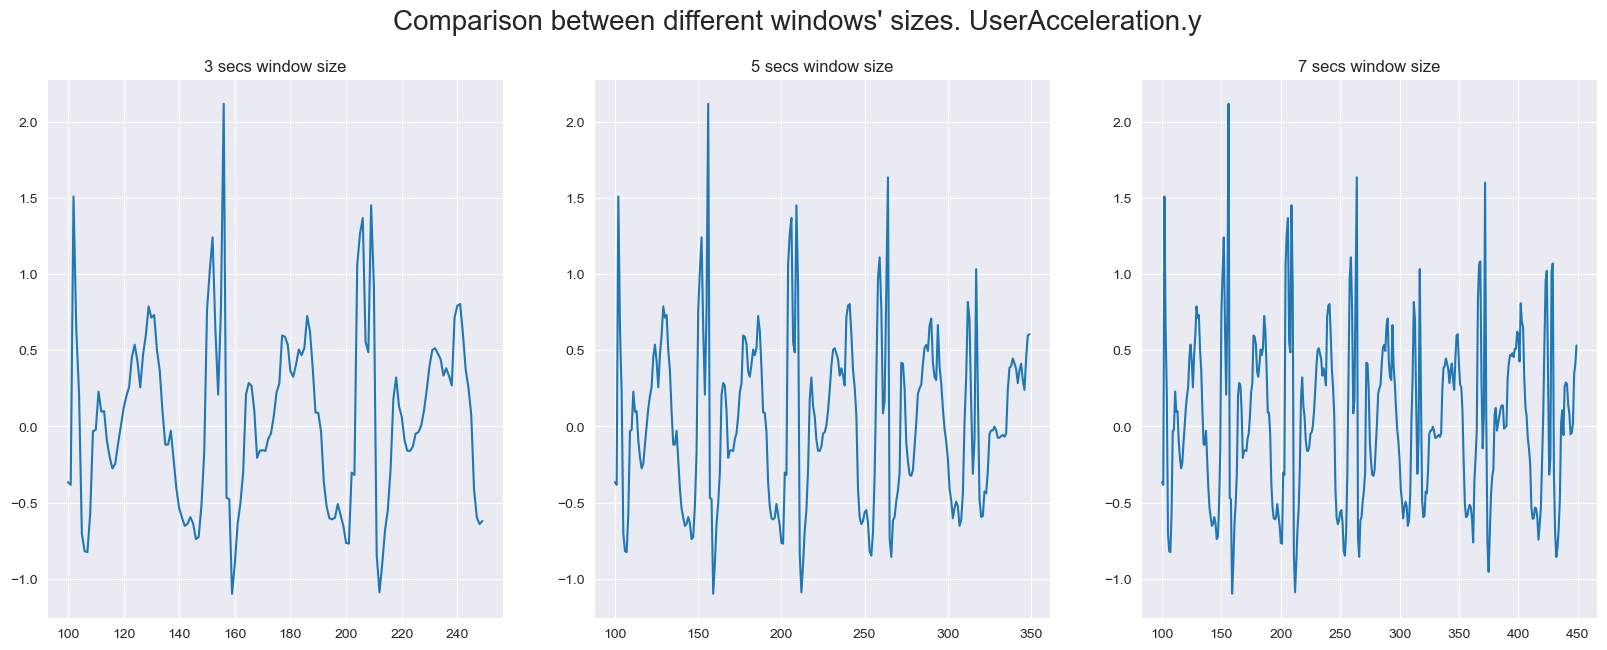

In [2]:
df=pd.read_csv("A_DeviceMotion_data/wlk_7/sub_1.csv")
f,axes=plt.subplots(1,3,figsize=(20,7))
f.suptitle("Comparison between different windows' sizes. UserAcceleration.y", fontsize=20)

axes[0].plot(df["userAcceleration.y"][100:250])
axes[0].title.set_text("3 secs window size")

axes[1].plot(df["userAcceleration.y"][100:350])
axes[1].title.set_text("5 secs window size")

axes[2].plot(df["userAcceleration.y"][100:450])
axes[2].title.set_text("7 secs window size")

At a first look we can see that 3 secs size has more or less 3 steps to deduce the activity that the candidate is doing.
Let's try to see how this translates when trying to classify these windows.

In [3]:
from creation_functions.utilities import create_time_series, preprocessing
df_3secs = preprocessing(create_time_series(labeled=True, mode="Collapsed", num_samples=150))
df_5secs = preprocessing(create_time_series(labeled=True, mode="Collapsed", num_samples=250))
df_7secs = preprocessing(create_time_series(labeled=True, mode="Collapsed", num_samples=350))

C:\Users\marco\Desktop\università\magistrale\data mining and machine learning\gitTest\clone\LavorettiFinali\creation_functions\utilities.py:50: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = only_numeric_dataset.corr().abs()
C:\Users\marco\Desktop\università\magistrale\data mining and machine learning\gitTest\clone\LavorettiFinali\creation_functions\utilities.py:50: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = only_numeric_dataset.corr().abs()
C:\Users\marco\Desktop\università\magistrale\data mining and machine learning\gitTest\clone\LavorettiFinali\creation_functions\utilities.py:50: FutureWarning: The default value o

[Text(0.5, 0, 'Window size'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, "Accuracy when window's size varies")]

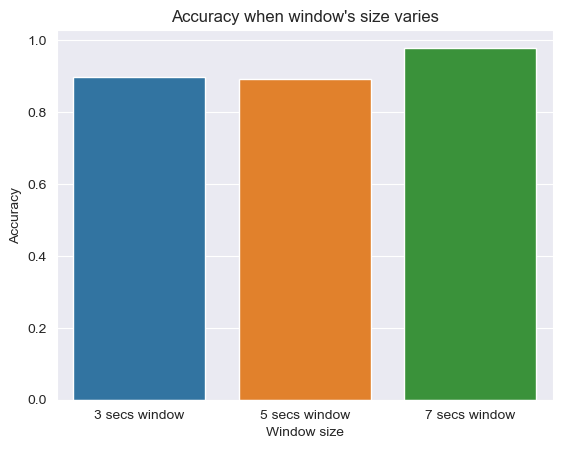

In [4]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
import numpy as np

knn_pipe=Pipeline([
    ("scaler", RobustScaler()),
    ("sampling", SMOTE()),
    ("feature-selector", SelectKBest(k=10)),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

res_3_secs = np.mean(cross_val_score(knn_pipe, df_3secs.drop("class", axis=1), df_3secs["class"], cv=KFold(5, shuffle=True, random_state=123)))
res_5_secs = np.mean(cross_val_score(knn_pipe, df_5secs.drop("class", axis=1), df_5secs["class"], cv=KFold(5, shuffle=True, random_state=123)))
res_7_secs = np.mean(cross_val_score(knn_pipe, df_7secs.drop("class", axis=1), df_7secs["class"], cv=KFold(5, shuffle=True, random_state=123)))


ax=sns.barplot(x=["3 secs window","5 secs window", "7 secs window"], y=[res_3_secs, res_5_secs, res_7_secs])
ax.set(xlabel="Window size", ylabel="Accuracy", title="Accuracy when window's size varies")

From the barplot above we can see that the window's size has some impact on the accuracy of the overall process of classification. In this case, the decision that we've taken is to prioritize responsiveness over accuracy because of the application that we'll be running later.

Now, let's talk about feature extraction. We decided to extract some features, both in time domain and in frequency domain, to describe our signals.
In particular, in time we decided to extract the mean, standard deviation, range, inter-quantile interval, kurtosis and skewness.
Concerning the frequency domain, let's compute the FFT of a signal to see what it's like

[Text(0.5, 0, 'Frequency (Hz)'), Text(0, 0.5, 'Amplitude')]

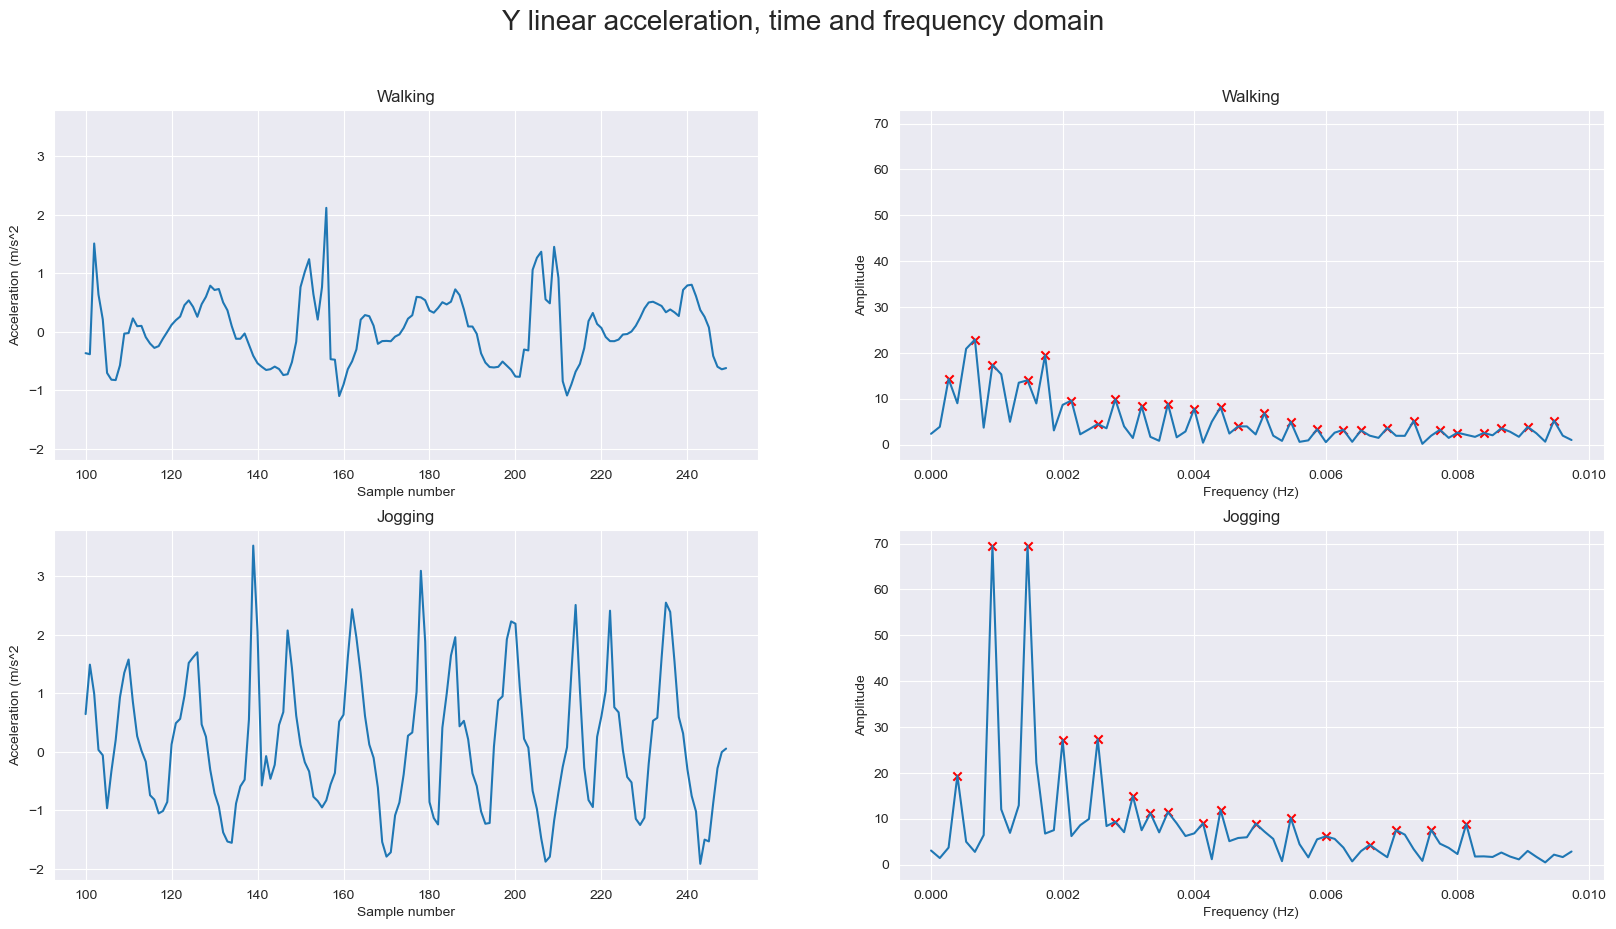

In [5]:
import detecta
from numpy.fft import fft

f,axes=plt.subplots(2,2,figsize=(20,10), sharey="col")

walking_df=pd.read_csv("A_DeviceMotion_data/wlk_7/sub_1.csv")["userAcceleration.y"][100:250]
jogging_df=pd.read_csv("A_DeviceMotion_data/jog_9/sub_1.csv")["userAcceleration.y"][100:250]

f.suptitle("Y linear acceleration, time and frequency domain", fontsize=20)

## TIME DOMAIN ##

axes[0][0].plot(walking_df)
axes[0][0].title.set_text("Walking")
axes[0][0].set(xlabel="Sample number", ylabel="Acceleration (m/s^2")
axes[1][0].plot(jogging_df)
axes[1][0].title.set_text("Jogging")
axes[1][0].set(xlabel="Sample number", ylabel="Acceleration (m/s^2")

## FREQUENCY DOMAIN ##
N=150
n=np.arange(-1,N)
sr=1/50
T=N/sr
freq=n/T
c=20

# FFT computing
n_oneside=N//2
x=freq[1:n_oneside]
y_wlk=np.abs(fft(walking_df)[1:n_oneside])
y_jog=np.abs(fft(jogging_df)[1:n_oneside])

# PEAKS computing
p_x_wlk=detecta.detect_peaks(y_wlk, mph=np.amax(y_wlk)/c)
p_x_jog=detecta.detect_peaks(y_jog, mph=np.amax(y_jog)/c)

#PLOT
axes[0][1].plot(x,y_wlk)
axes[0][1].scatter(p_x_wlk/T, y_wlk[p_x_wlk], marker="x", c="red")
axes[0][1].title.set_text("Walking")
axes[0][1].set(xlabel="Frequency (Hz)", ylabel="Amplitude")
axes[1][1].plot(x,y_jog)
axes[1][1].scatter(p_x_jog/T, y_jog[p_x_jog], marker="x", c="red")
axes[1][1].title.set_text("Jogging")
axes[1][1].set(xlabel="Frequency (Hz)", ylabel="Amplitude")

We can easily see that, taking as example walking and jogging, there are some noticeable differences into the frequency domain. The amplitude of the peaks in particular is different, especially in the first part of the graph.
After some time spent in deciding how to extract features in the frequency domain, we decided to take the first 5 peaks in the FFT, both x and y value. This decision was highly supported by some papers that we studied (for example: https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/)

We have to pay some extra attention to the "detecta" library. In particular the "detect_peaks" function takes an argument, which is min peak height. In this case, in order to not select some useless peaks between the first 5 ones, we started from a high mph=(max of all the values / c) with c=20 and if 5 peaks are not present, then increment c until we have 5. Let's see an example where this mph doesn't work.

[Text(0.5, 1.0, 'c=30')]

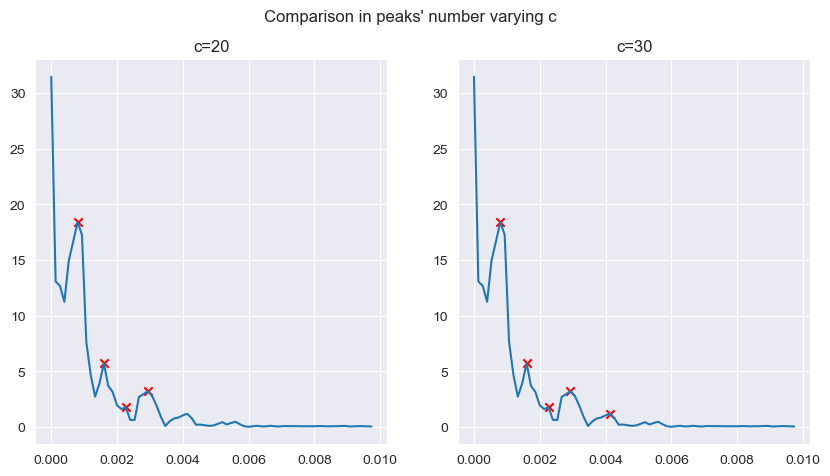

In [6]:
from feature_extraction import noise_filter
df_without_visible_peaks = noise_filter(pd.read_csv("A_DeviceMotion_data/std_6/sub_24.csv"))["rotationRate.x"][3600:3750]

## FREQUENCY DOMAIN ##
N=150
n=np.arange(-1,N)
sr=1/50
T=N/sr
freq=n/T
c=20

# FFT computing
n_oneside=N//2
x=freq[1:n_oneside]
y_sit=np.abs(fft(df_without_visible_peaks)[1:n_oneside])

f,axes=plt.subplots(1,2,figsize=(10,5))
f.suptitle("Comparison in peaks' number varying c")

# PEAKS computing
p_x_sit_20=detecta.detect_peaks(y_sit, mph=np.amax(y_sit)/c)
c+=10
p_x_sit_30=detecta.detect_peaks(y_sit, mph=np.amax(y_sit)/c)

axes[0].plot(x,y_sit)
axes[0].scatter(p_x_sit_20/T, y_sit[p_x_sit_20], marker="x", c="red")
axes[0].set(title="c=20")

axes[1].plot(x,y_sit)
axes[1].scatter(p_x_sit_30/T, y_sit[p_x_sit_30], marker="x", c="red")
axes[1].set(title="c=30")

Now that we fixed the window's size at 3 secs, we're going to investigate over the usefulness of the features that we've extracted during the process. We've already pointed out that some features are highly correlated.

In [7]:
df_collapsed =  create_time_series()

In [8]:
df_collapsed.shape

(8882, 99)

Let's remove the ones that are correlated to see how many features we have after

In [9]:
df_collapsed_uncorrelated = preprocessing(df_collapsed)
df_collapsed_uncorrelated.shape

C:\Users\marco\Desktop\università\magistrale\data mining and machine learning\gitTest\clone\LavorettiFinali\creation_functions\utilities.py:50: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = only_numeric_dataset.corr().abs()


(8855, 86)

[Text(0, 0.5, 'Number of features'),
 Text(0.5, 1.0, 'Number of features before and after removing correlated ones')]

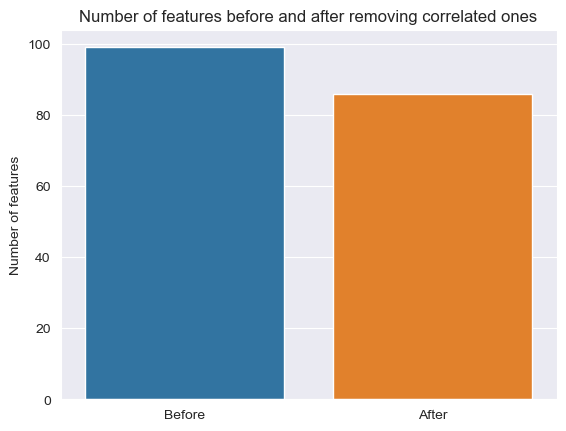

In [10]:
ax=sns.barplot(x=["Before", "After"], y=[df_collapsed.shape[1], df_collapsed_uncorrelated.shape[1]])

ax.set(ylabel="Number of features", title="Number of features before and after removing correlated ones")

Now it's all set for feature reduction. We know that, by collapsing the dataset into windows, we extracted a high number of features. Let's see if we can discard some of them, obtaining good results.

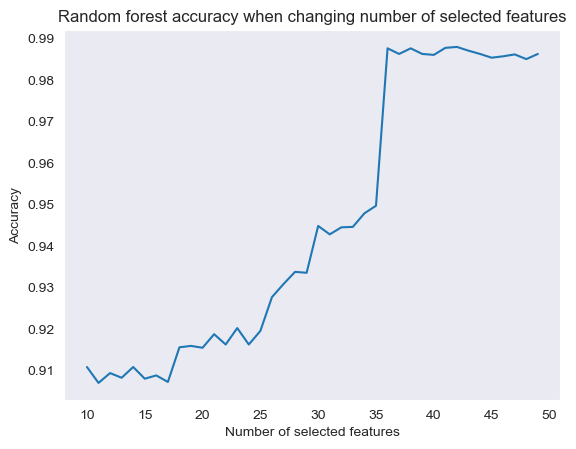

In [11]:
from sklearn.ensemble import RandomForestClassifier

X=df_collapsed_uncorrelated.drop("class", axis=1)
y=df_collapsed_uncorrelated["class"]

results_list=[]

for k in range (10,50):
    pipe=Pipeline([
        ("scaler", RobustScaler()),
        ("sampling", SMOTE()),
        ("feature_selection",SelectKBest(k=k)),
        ("classifier", RandomForestClassifier(n_jobs=-1))
    ])
    results=cross_val_score(pipe, X, y, cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1 )
    results_list.append(np.mean(results))

x=np.arange(10, 50)
plt.plot(x, results_list)
plt.xlabel("Number of selected features")
plt.ylabel("Accuracy")
plt.title("Random forest accuracy when changing number of selected features")
plt.grid()

As we can see, if we use 10 features we obtain an accuracy of 0.91, while if we consider to arrive at 40, we obtain an accuracy of 0.99.